In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [79]:
# 1. Load MiDaS Model for Depth Estimation
def load_midas_model():
    """
    Loads the MiDaS model for depth estimation.

    Returns:
        model (torch.nn.Module): The loaded MiDaS model.
        transform (torchvision.transforms.Compose): The transformation applied to input images.
    """
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    model.eval()
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
    return model, transform

In [80]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image

class FoodSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Binarize the mask
        mask = (mask > 0.5).float()
        
        return image, mask

In [81]:
class UNet(nn.Module):
    """
    UNet is a convolutional neural network architecture for image segmentation.
    
    Args:
        in_channels (int): Number of input channels. Default is 3.
        out_channels (int): Number of output channels. Default is 1.
    
    Attributes:
        encoder (nn.Module): Encoder part of the UNet model.
        decoder (nn.Module): Decoder part of the UNet model.
    
    Methods:
        forward(x): Forward pass of the UNet model.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder = timm.create_model("resnet34", features_only=True, pretrained=True)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )
    
    def forward(self, x):
        """
        Forward pass of the UNet model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, height, width).
        """
        enc_outs = self.encoder(x)
        out = self.decoder(enc_outs[-1])
        return torch.sigmoid(out)

In [82]:
def load_unet_model():
    """
    Load the pre-trained UNet model for depth estimation.

    Returns:
        model (UNet): The loaded UNet model.
    """
    model = UNet()
    try:
        model.load_state_dict(torch.load("path_to_pretrained_unet.pth", map_location='cpu'))
    except FileNotFoundError:
        print("Pre-trained U-Net model not found. Using untrained model.")
    model.eval()
    return model

In [83]:
def estimate_depth(model, transform, image):
    """
    Estimates the depth of an image using a given model and transformation.

    Parameters:
    model (torch.nn.Module): The depth estimation model.
    transform (torchvision.transforms.Compose): The transformation to be applied to the image.
    image (PIL.Image.Image): The input image.

    Returns:
    numpy.ndarray: The estimated depth map.
    """
    input_batch = transform(image)  # Add batch dimension
    print("Input Batch Shape",input_batch.shape)
    with torch.no_grad():
        depth = model(input_batch)
        print("Depth Shape",depth.shape)
        # Fix: Ensure depth has the correct shape [batch_size, channels, height, width]
        if len(depth.shape) == 5:
            
            depth = depth.squeeze(1)  # Remove the extra dimension
            
        depth = depth.squeeze().cpu().numpy()
        depth = cv2.resize(depth, (image.shape[1], image.shape[0]))
    return depth

In [84]:
def segment_food(unet_model, image):
    print("Image Shape",image.shape)
    """
    Segment food in an image using a U-Net model.

    Parameters:
    - unet_model (torch.nn.Module): The U-Net model used for segmentation.
    - image (PIL.Image.Image): The input image to be segmented.

    Returns:
    - numpy.ndarray: The binary mask indicating the segmented food regions.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
    ])
    input_tensor = transform(image)
    
    print("Input Tensor Shape",input_tensor.shape)
    input_tensor = input_tensor.unsqueeze(0)
    with torch.no_grad():
        mask = unet_model(input_tensor)
        mask = mask.squeeze().cpu().numpy()
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
        return mask > 0.5

In [85]:
def calculate_volume(depth_map, mask, pixel_area=0.1):
    volume = np.sum(depth_map[mask]) * pixel_area
    return volume

In [86]:
def main():
    """
    Main function to perform depth estimation and volume calculation for a given image.
    
    Args:
        image_path (str): The path to the input image file.
    """
    # Load Image
    image_path = 'pexels-pixabay-206959.jpg'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    midas_model, midas_transform = load_midas_model()
    unet_model = load_unet_model()
    
    food_mask = segment_food(unet_model, image)
    
    depth_map = estimate_depth(midas_model, midas_transform, image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Segmented Food")
    plt.imshow(food_mask, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='viridis')
    plt.show()
    
    volume = calculate_volume(depth_map, food_mask)
    print(f"Estimated Volume: {volume:.2f} cubic units")

Using cache found in /Users/aariziqbal/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/aariziqbal/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/aariziqbal/.cache/torch/hub/intel-isl_MiDaS_master
/var/folders/5y/dhp8v_nd1z7frmxjg40cw7m80000gn/T/ipykernel_14584/667759408.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Pre-trained U-Net model not found. Using untrained model.
Image Shape (3504, 5488, 3)
Input Tensor Shape torch.Size([3, 256, 256])
Input Batch Shape torch.Size([1, 3, 160, 256])
Depth Shape torch.Size([1, 160, 256])


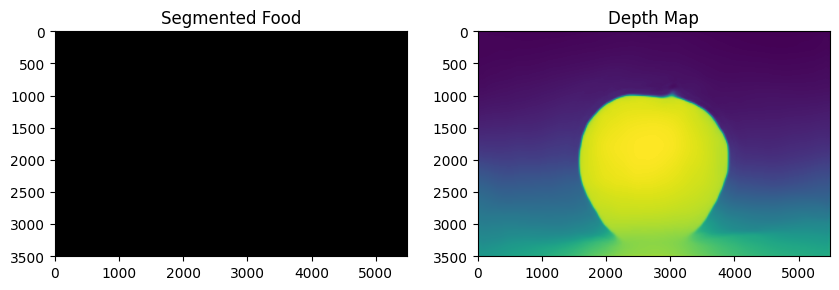

Estimated Volume: 0.00 cubic units


In [87]:
main()